In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import cvxpy as cp
from pypfopt import EfficientFrontier, risk_models, expected_returns, objective_functions, BlackLittermanModel
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# cstat = pd.read_feather('compustat.feather')
cstat = pd.read_feather('compustat_ind.feather')
cstat.reset_index(inplace=True)
cstat = cstat.rename(columns={'datadate':'DATE', 'LPERMNO':'PERMNO'})
cstat['DATE'] = pd.to_datetime(cstat['DATE'])
cstat['rdq'] = pd.to_datetime(cstat['rdq'])
cstat.loc[cstat['rdq'].isna(), 'rdq'] = cstat['DATE'] + DateOffset(months=3)
cstat.drop(['index'], axis=1, inplace=True)
cstat.head()

,GVKEY,PERMNO,DATE,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,...,datafqtr,rdq,actq,atq,ibq,niq,saleq,seqq,costat,naics
0,1003,10031,1989-01-31,1988,4,INDL,C,D,STD,USD,...,1988Q4,1989-04-30,14.656,16.280,-5.419,-5.419,8.653,-0.194,I,442110.0
1,1003,10031,1989-04-30,1989,1,INDL,C,D,STD,USD,...,1989Q1,1989-07-30,NaN,NaN,-0.753,-0.753,5.194,NaN,I,442110.0
2,1003,10031,1989-07-31,1989,2,INDL,C,D,STD,USD,...,1989Q2,1989-10-31,12.046,13.328,0.415,2.748,4.384,1.801,I,442110.0
3,1004,54594,1989-02-28,1988,3,INDL,C,D,STD,USD,...,1988Q3,1989-03-20,247.407,347.139,6.045,6.045,102.318,166.042,A,423860.0
4,1004,54594,1989-05-31,1988,4,INDL,C,D,STD,USD,...,1988Q4,1989-07-18,257.048,356.391,7.365,7.365,113.390,171.580,A,423860.0


In [3]:
crsp = pd.read_feather('crsp.feather')
crsp.reset_index(inplace=True)
crsp = crsp.rename(columns={'date':'DATE'})
crsp['DATE'] = pd.to_datetime(crsp['DATE'])

In [4]:
crsp.drop(['index'], axis=1, inplace=True)
crsp.head()

,PERMNO,DATE,SHRCD,TICKER,COMNAM,NAICS,DIVAMT,PRC,VOL,RET,BID,ASK,SHROUT,OPENPRC,RETX,sprtrn
0,10001,1990-01-02,11,GFGC,GREAT FALLS GAS CO,NaN,NaN,10.1250,1900.0,0.000000,10.0,10.125,1022.0,NaN,0.000000,0.017799
1,10001,1990-01-03,11,GFGC,GREAT FALLS GAS CO,NaN,NaN,10.0000,1300.0,-0.012346,10.0,10.125,1022.0,NaN,-0.012346,-0.002586
2,10001,1990-01-04,11,GFGC,GREAT FALLS GAS CO,NaN,NaN,10.0000,1300.0,0.000000,10.0,10.125,1022.0,NaN,0.000000,-0.008613
3,10001,1990-01-05,11,GFGC,GREAT FALLS GAS CO,NaN,NaN,-10.0625,0.0,0.006250,10.0,10.125,1022.0,NaN,0.006250,-0.009756
4,10001,1990-01-08,11,GFGC,GREAT FALLS GAS CO,NaN,NaN,10.1250,900.0,0.006211,10.0,10.125,1022.0,NaN,0.006211,0.004514


In [5]:
ff = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows=5,
                 names=['DATE', 'Mkt-RF', 'SMB', 'HML', 'RF'])[:-1]
ff['DATE'] = pd.to_datetime(ff['DATE'], format = '%Y%m%d')
ff = ff.set_index('DATE')
ff

,Mkt-RF,SMB,HML,RF
DATE,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2024-02-23,0.02,0.28,-0.03,0.021
2024-02-26,-0.26,1.00,-0.11,0.021
2024-02-27,0.27,1.19,-0.45,0.021


In [6]:
ff.tail()

,Mkt-RF,SMB,HML,RF
DATE,,,,
2024-02-23,0.02,0.28,-0.03,0.021
2024-02-26,-0.26,1.00,-0.11,0.021
2024-02-27,0.27,1.19,-0.45,0.021
2024-02-28,-0.26,-0.85,0.00,0.021
2024-02-29,0.54,-0.34,0.98,0.021


# 1. Data Cleaning

## 1.1 CRSP Data Cleaning

In [7]:
list(crsp.columns)

['PERMNO',
 'DATE',
 'SHRCD',
 'TICKER',
 'COMNAM',
 'NAICS',
 'DIVAMT',
 'PRC',
 'VOL',
 'RET',
 'BID',
 'ASK',
 'SHROUT',
 'OPENPRC',
 'RETX',
 'sprtrn']

In [8]:
# Make close price into absolute value
crsp['PRC'] = np.abs(crsp['PRC'])

# Drop rows with volume = 0
crsp = crsp[crsp['VOL'] > 0]

# Compute market value as MV, and remove rows with market value less than $50M. SHROUT is in thousands.
crsp['MV'] = crsp['SHROUT'] * crsp['PRC']
crsp = crsp[crsp['MV'] > 50000]

# Drop unused columns
crsp.drop(['SHRCD','COMNAM','NAICS','DIVAMT','BID','ASK','sprtrn','TICKER'], axis=1, inplace=True)

# For NA values in RET and RETX, we manually compute the return using PRC
crsp.loc[crsp['RET'].isna(), 'RET'] = crsp['PRC'] / crsp['PRC'].shift()
crsp.loc[crsp['RETX'].isna(), 'RETX'] = crsp['PRC'] / crsp['PRC'].shift()

In [9]:
crsp.set_index(['PERMNO', 'DATE'], inplace=True)
crsp.sort_index(inplace=True)
crsp.head()

PRC      VOL       RET  SHROUT  OPENPRC      RETX  \
PERMNO DATE                                                              
10001  2010-04-27  11.61  27800.0  0.045946  4361.0    11.13  0.045946   
       2010-04-29  11.52  12100.0  0.024920  4361.0    11.30  0.024920   
       2010-04-30  11.39  23400.0 -0.011285  6070.0    11.98 -0.011285   
       2010-05-03  11.80  10000.0  0.035996  6070.0    11.65  0.035996   
       2010-05-04  11.56  11100.0 -0.020339  6070.0    11.50 -0.020339   

                         MV  
PERMNO DATE                  
10001  2010-04-27  50631.21  
       2010-04-29  50238.72  
       2010-04-30  69137.30  
       2010-05-03  71626.00  
       2010-05-04  70169.20

## 1.2 COMPUSTAT Data Cleaning

In [10]:
# Drop unused columns
# This is used for the dataset compustat.feather. It does not have NAICS codes
# cstat.drop(['GVKEY','fyearq','fqtr','fyr','indfmt','consol','popsrc','datafmt','tic','conm','curcdq','datacqtr',
#             'datafqtr','pdateq','cshfdq','cshoq','cshprq','cdvcy','dvy','iby','costat','dvpspq','spcindcd'],
#            axis=1, inplace=True)

cstat.drop(['GVKEY','fyearq','fqtr','indfmt','consol','popsrc','datafmt','curcdq','datacqtr',
            'datafqtr','costat'],
           axis=1, inplace=True)

In [11]:
list(cstat.columns)

['PERMNO',
 'DATE',
 'rdq',
 'actq',
 'atq',
 'ibq',
 'niq',
 'saleq',
 'seqq',
 'naics']

In [12]:
# Filter out the financial institutions (NAICS sector 52, so their NAICS starts with 52).
cstat['naics_str'] = cstat['naics'].astype(str)
cstat = cstat[~cstat['naics_str'].str.startswith('52')]
cstat.drop(columns='naics_str',inplace=True)

In [13]:
# DATE: reporting date of earnings, CA: Current Asset, IB: Income Before Extraordinary Items, NI: Net Income
# SALE: Revenue, Equity: Stockholder's Equity
cstat.rename(columns={'DATE':'DATADATE','rdq':'DATE','actq':'CA','ibq':'IB','niq':'NI','saleq':'SALE',
                      'seqq':'Equity', 'atq':'Asset'}, inplace=True)

In [14]:
# Set cstat index and sort the data by index
cstat.set_index(['PERMNO', 'DATE'], inplace=True)
cstat.sort_index(inplace=True)
cstat.head()

DATADATE     CA   Asset     IB     NI   SALE  Equity  \
PERMNO DATE                                                                
10001  1989-06-30 1989-03-31  5.700  20.669  0.720  0.720  9.992   6.172   
       1989-08-29 1989-06-30  3.577  18.565  0.245  0.245  4.826   6.321   
       1989-11-03 1989-09-30  3.002  18.088 -0.201 -0.201  2.883   6.129   
       1990-02-20 1989-12-31  5.416  20.484  0.569  0.569  7.615   6.599   
       1990-05-10 1990-03-31  4.701  20.245  0.728  0.728  8.350   7.243   

                      naics  
PERMNO DATE                  
10001  1989-06-30  221210.0  
       1989-08-29  221210.0  
       1989-11-03  221210.0  
       1990-02-20  221210.0  
       1990-05-10  221210.0

In [15]:
# Merge crsp and cstat
df = crsp.merge(cstat[['CA', 'Asset', 'IB', 'NI', 'SALE', 'Equity']], how='outer', on=['PERMNO','DATE'])

In [16]:
# For missing values in financials, we fill them using the last valid entry of the company.
# If there are still missing values, it arises from issues with the original dataset
# and there is not much to do.
df.reset_index(inplace=True)
df.sort_values(by=['PERMNO','DATE'], inplace=True)
df[['CA','Asset','IB','NI','SALE','Equity']] = df.groupby('PERMNO')[['CA','Asset','IB',
                                                                     'NI','SALE','Equity']].ffill()

In [17]:
df.set_index(['PERMNO', 'DATE'], inplace=True)
df.sort_index(inplace=True)
df.head()

PRC  VOL  RET  SHROUT  OPENPRC  RETX  MV     CA   Asset  \
PERMNO DATE                                                                  
10001  1989-06-30  NaN  NaN  NaN     NaN      NaN   NaN NaN  5.700  20.669   
       1989-08-29  NaN  NaN  NaN     NaN      NaN   NaN NaN  3.577  18.565   
       1989-11-03  NaN  NaN  NaN     NaN      NaN   NaN NaN  3.002  18.088   
       1990-02-20  NaN  NaN  NaN     NaN      NaN   NaN NaN  5.416  20.484   
       1990-05-10  NaN  NaN  NaN     NaN      NaN   NaN NaN  4.701  20.245   

                      IB     NI   SALE  Equity  
PERMNO DATE                                     
10001  1989-06-30  0.720  0.720  9.992   6.172  
       1989-08-29  0.245  0.245  4.826   6.321  
       1989-11-03 -0.201 -0.201  2.883   6.129  
       1990-02-20  0.569  0.569  7.615   6.599  
       1990-05-10  0.728  0.728  8.350   7.243

In [18]:
# Drop observations without valid price or return.
df = df.dropna(subset=['PRC','RET','RETX'])

In [19]:
df.head()

PRC      VOL       RET  SHROUT  OPENPRC      RETX  \
PERMNO DATE                                                              
10001  2010-04-27  11.61  27800.0  0.045946  4361.0    11.13  0.045946   
       2010-04-29  11.52  12100.0  0.024920  4361.0    11.30  0.024920   
       2010-04-30  11.39  23400.0 -0.011285  6070.0    11.98 -0.011285   
       2010-05-03  11.80  10000.0  0.035996  6070.0    11.65  0.035996   
       2010-05-04  11.56  11100.0 -0.020339  6070.0    11.50 -0.020339   

                         MV      CA   Asset     IB     NI    SALE  Equity  
PERMNO DATE                                                                
10001  2010-04-27  50631.21  25.641  78.626  4.343  4.343  19.556  35.688  
       2010-04-29  50238.72  25.641  78.626  4.343  4.343  19.556  35.688  
       2010-04-30  69137.30  25.641  78.626  4.343  4.343  19.556  35.688  
       2010-05-03  71626.00  25.641  78.626  4.343  4.343  19.556  35.688  
       2010-05-04  70169.20  25.641  78.626  4.343  4.343  19.556  35.688

## 1.3 Fama-French Research Data Cleaning

In [20]:
ff.head()

,Mkt-RF,SMB,HML,RF
DATE,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009


In [21]:
# The original data is in percentages. This changes it to decimals.
ff = ff/100

# Merge ff into df
df.reset_index(inplace=True)
df = df.merge(ff[['Mkt-RF','SMB','HML','RF']], how='left', on='DATE')

In [22]:
df.set_index(['PERMNO', 'DATE'], inplace=True)
df.sort_index(inplace=True)
df = df.iloc[df.index.get_level_values('DATE') >= '2004-01-01']
df1 = df.iloc[df.index.get_level_values('DATE') >= '2016-01-01']
df = df.iloc[df.index.get_level_values('DATE') < '2016-01-01']
df.head()

PRC      VOL       RET  SHROUT  OPENPRC      RETX  \
PERMNO DATE                                                              
10001  2010-04-27  11.61  27800.0  0.045946  4361.0    11.13  0.045946   
       2010-04-29  11.52  12100.0  0.024920  4361.0    11.30  0.024920   
       2010-04-30  11.39  23400.0 -0.011285  6070.0    11.98 -0.011285   
       2010-05-03  11.80  10000.0  0.035996  6070.0    11.65  0.035996   
       2010-05-04  11.56  11100.0 -0.020339  6070.0    11.50 -0.020339   

                         MV      CA   Asset     IB     NI    SALE  Equity  \
PERMNO DATE                                                                 
10001  2010-04-27  50631.21  25.641  78.626  4.343  4.343  19.556  35.688   
       2010-04-29  50238.72  25.641  78.626  4.343  4.343  19.556  35.688   
       2010-04-30  69137.30  25.641  78.626  4.343  4.343  19.556  35.688   
       2010-05-03  71626.00  25.641  78.626  4.343  4.343  19.556  35.688   
       2010-05-04  70169.20  25.641  78.626  4.343  4.343  19.556  35.688   

                   Mkt-RF     SMB     HML       RF  
PERMNO DATE                                         
10001  2010-04-27 -0.0234  0.0012 -0.0135  0.00001  
       2010-04-29  0.0134  0.0043  0.0056  0.00001  
       2010-04-30 -0.0172 -0.0097 -0.0088  0.00001  
       2010-05-03  0.0136  0.0062  0.0060  0.00001  
       2010-05-04 -0.0250 -0.0056 -0.0092  0.00001

# 2. Fundamental Investing Strategies

## 2.1 Value Investing vs Growth Investing

In [23]:
strat = df.copy()

# Calculate P/E using market value and net income. Since MV is in thousands,
# and net income is in millions, we divide by 1000.
strat['PE'] = strat['MV'] / strat['NI'] / 1000

# Rank the PE so that firms with smaller PE on each day has a smaller (closer to 0) rank
# Shift the PE by one day to avoid look-ahead bias
strat['PEValueRank'] = strat['PE'].shift().groupby('DATE').rank()

# Rank the PE so that firms with larger PE on each day has a smaller (closer to 0) rank
strat['PEGrowthRank'] = strat['PE'].shift().groupby('DATE').rank(ascending=False)

# Select the top 50 value stocks
PEValue50 = strat.loc[strat['PEValueRank'] < 50]

# Select the top 50 growth stocks
PEGrowth50 = strat.loc[strat['PEGrowthRank'] < 50]

# Construct an equal-weighted value portfolio everyday with top 50 value stocks
PEValuePort = PEValue50['RETX'].groupby('DATE').sum()/50
PEValuePort = PEValuePort.to_frame().merge(ff['RF'], how='left', on='DATE')
PEValuePort['ExcessRet'] = PEValuePort['RETX'] - PEValuePort['RF']

# Construct an equal-weighted growth portfolio everyday with top 50 growth stocks
PEGrowthPort = PEGrowth50['RETX'].groupby('DATE').sum()/50
PEGrowthPort = PEGrowthPort.to_frame().merge(ff['RF'], how='left', on='DATE')
PEGrowthPort['ExcessRet'] = PEGrowthPort['RETX'] - PEGrowthPort['RF']

In [24]:
PEValueRet = PEValuePort['RETX'].mean()
PEValueVol = PEValuePort['RETX'].std()
PEGrowthRet = PEGrowthPort['RETX'].mean()
PEGrowthVol = PEGrowthPort['RETX'].std()

In [25]:
print('Annulized return for PE Value portfolio: %2.4f' %(PEValueRet * 252))
print('Annulized return for PE Growth portfolio: %2.4f' %(PEGrowthRet * 252))
print('Annulized volatility for PE Value portfolio: %2.4f' %(PEValueVol * np.sqrt(252)))
print('Annulized volatility for PE Growth portfolio: %2.4f' %(PEGrowthVol * np.sqrt(252)))

Annulized return for PE Value portfolio: 1.1387
Annulized return for PE Growth portfolio: 0.3128
Annulized volatility for PE Value portfolio: 3.0293
Annulized volatility for PE Growth portfolio: 0.3685


In [26]:
PEValueSharpe = PEValuePort['ExcessRet'].mean() / PEValueVol * np.sqrt(252)
PEGrowthSharpe = PEGrowthPort['ExcessRet'].mean() / PEGrowthVol * np.sqrt(252)
print('Annulized Sharpe Ratio for PE Value portfolio: %2.4f' %(PEValueSharpe))
print('Annulized Sharpe Ratio for PE Growth portfolio: %2.4f' %(PEGrowthSharpe))

Annulized Sharpe Ratio for PE Value portfolio: 0.3717
Annulized Sharpe Ratio for PE Growth portfolio: 0.8144


## 2.2 Investing in high earnings relative to total assets

In [27]:
strat = df.copy()
strat['earnings'] = strat['IB'] / strat['Asset'] / 1000
strat['earningsRank'] = strat['earnings'].shift().groupby('DATE').rank(ascending=False)
earnings50 = strat.loc[strat['earningsRank'] < 50]
earningsPort = earnings50['RETX'].groupby('DATE').sum()/50

In [28]:
earningsStat = earningsPort.describe()

In [29]:
earningsRet = earningsStat['mean']
earningsVol = earningsStat['std']

In [30]:
print('Annulized return for high earning portfolio: %2.4f' %(earningsRet * 252))
print('Annulized volatility for high earning portfolio: %2.4f' %(earningsVol * np.sqrt(252)))

Annulized return for high earning portfolio: 0.4290
Annulized volatility for high earning portfolio: 0.2808


In [31]:
earningsPort = earningsPort.to_frame().merge(ff['RF'], how='left', on='DATE')
earningsPort['ExcessRet'] = earningsPort['RETX'] - earningsPort['RF']
earningsSharpe = earningsPort['ExcessRet'].mean() / earningsVol * np.sqrt(252)
print('Annulized Sharpe Ratio for high earning portfolio: %2.4f' %(earningsSharpe))

Annulized Sharpe Ratio for high earning portfolio: 1.4824


## 2.3 Investing in high profit margins

In [32]:
strat = df.copy()
strat['margin'] = strat['NI'] / strat['SALE'] / 1000
strat['marginRank'] = strat['margin'].shift().groupby('DATE').rank(ascending=False)
margin50 = strat.loc[strat['marginRank'] < 50]
marginPort = margin50['RETX'].groupby('DATE').sum()/50

In [33]:
marginStat = marginPort.describe()

In [34]:
marginRet = marginStat['mean']
marginVol = marginStat['std']

In [35]:
print('Annulized return for high margin portfolio: %2.4f' %(marginRet * 252))
print('Annulized volatility for high margin portfolio: %2.4f' %(marginVol * np.sqrt(252)))

Annulized return for high margin portfolio: 0.7306
Annulized volatility for high margin portfolio: 0.5185


In [36]:
marginPort = marginPort.to_frame().merge(ff['RF'], how='left', on='DATE')
marginPort['ExcessRet'] = marginPort['RETX'] - marginPort['RF']
marginSharpe = marginPort['ExcessRet'].mean() / marginVol * np.sqrt(252)
print('Annulized Sharpe Ratio for profitable portfolio: %2.4f' %(marginSharpe))

Annulized Sharpe Ratio for profitable portfolio: 1.3845


## 2.4 Investing in small companies (SMB)

In [37]:
strat = df.copy()
strat['sizeRank'] = strat['Asset'].shift().groupby('DATE').rank()
size50 = strat.loc[strat['sizeRank'] < 50]
sizePort = size50['RETX'].groupby('DATE').sum()/50

In [38]:
sizeStat = sizePort.describe()

In [39]:
sizeRet = sizeStat['mean']
sizeVol = sizeStat['std']

In [40]:
print('Annulized return for small company portfolio: %2.4f' %(sizeRet * 252))
print('Annulized volatility for small company portfolio: %2.4f' %(sizeVol * np.sqrt(252)))

Annulized return for small company portfolio: 2.2978
Annulized volatility for small company portfolio: 0.9050


In [41]:
sizePort = sizePort.to_frame().merge(ff['RF'], how='left', on='DATE')
sizePort['ExcessRet'] = sizePort['RETX'] - sizePort['RF']
sizeSharpe = sizePort['ExcessRet'].mean() / sizeVol * np.sqrt(252)
print('Annulized Sharpe Ratio for small company portfolio: %2.4f' %(sizeSharpe))

Annulized Sharpe Ratio for small company portfolio: 2.5248


# 3. Technical Indicators

# 3.1 Double Moving Average (DMA)

In [42]:
# Compute the 10-, 50-, and 100-day moving averages
strat = df.copy()
strat['10ma'] = strat.groupby('PERMNO')['PRC'].rolling(10).mean().droplevel(0)
strat['50ma'] = strat.groupby('PERMNO')['PRC'].rolling(50).mean().droplevel(0)
strat['100ma'] = strat.groupby('PERMNO')['PRC'].rolling(100).mean().droplevel(0)

strat['7ma'] = strat.groupby('PERMNO')['PRC'].rolling(7).mean().droplevel(0)
strat['21ma'] = strat.groupby('PERMNO')['PRC'].rolling(21).mean().droplevel(0)

In [43]:
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['10ma'] > strat['50ma'], 'signal'] = 1
strat.loc[strat['10ma'] < strat['50ma'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['dmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
# stratLong = strat.loc[strat['lagSignal'] < 0]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
dmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['dmaRet'].groupby('DATE').sum()/50

dmaRet = dmaPort.mean()
dmaVol = dmaPort.std()

In [44]:
print('Annulized return for DMA portfolio: %2.4f' %(dmaRet * 252))
print('Annulized volatility for DMA portfolio: %2.4f' %(dmaVol * np.sqrt(252)))

Annulized return for DMA portfolio: 0.1028
Annulized volatility for DMA portfolio: 0.1699


In [45]:
dmaPort = dmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
dmaPort['ExcessRet'] = dmaPort['dmaRet'] - dmaPort['RF']
dmaSharpe = dmaPort['ExcessRet'].mean() / dmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DMA portfolio: %2.4f' %(dmaSharpe))

Annulized Sharpe Ratio for DMA portfolio: 0.5300


In [46]:
# Test the 10-, 100-day strategy
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['10ma'] > strat['100ma'], 'signal'] = 1
strat.loc[strat['10ma'] < strat['100ma'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['dmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
dmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['dmaRet'].groupby('DATE').sum()/50

dmaRet = dmaPort.mean()
dmaVol = dmaPort.std()
print('Annulized return for DMA portfolio: %2.4f' %(dmaRet * 252))
print('Annulized volatility for DMA portfolio: %2.4f' %(dmaVol * np.sqrt(252)))

Annulized return for DMA portfolio: -0.0803
Annulized volatility for DMA portfolio: 0.1579


In [47]:
dmaPort = dmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
dmaPort['ExcessRet'] = dmaPort['dmaRet'] - dmaPort['RF']
dmaSharpe = dmaPort['ExcessRet'].mean() / dmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DMA portfolio: %2.4f' %(dmaSharpe))

Annulized Sharpe Ratio for DMA portfolio: -0.5899


In [48]:
# Test the 7-, 21-day strategy
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['7ma'] > strat['21ma'], 'signal'] = 1
strat.loc[strat['7ma'] < strat['21ma'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['dmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
dmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['dmaRet'].groupby('DATE').sum()/50

dmaRet = dmaPort.mean()
dmaVol = dmaPort.std()
print('Annulized return for DMA portfolio: %2.4f' %(dmaRet * 252))
print('Annulized volatility for DMA portfolio: %2.4f' %(dmaVol * np.sqrt(252)))

Annulized return for DMA portfolio: 0.2215
Annulized volatility for DMA portfolio: 0.2731


In [49]:
dmaPort = dmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
dmaPort['ExcessRet'] = dmaPort['dmaRet'] - dmaPort['RF']
dmaSharpe = dmaPort['ExcessRet'].mean() / dmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DMA portfolio: %2.4f' %(dmaSharpe))

Annulized Sharpe Ratio for DMA portfolio: 0.7644


## 3.2 Double Exponential Moving Average

In [50]:
# Calculate Exponential Moving Averages
strat = df.copy()
strat['ema_10'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['ema_50'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

# Calculate the Double EMAs for the same periods
strat['dema_10'] = strat.groupby('PERMNO')['ema_10'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['dema_50'] = strat.groupby('PERMNO')['ema_50'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

# Calculate DEMA
strat['dema_10_final'] = 2 * strat['ema_10'] - strat['dema_10']
strat['dema_50_final'] = 2 * strat['ema_50'] - strat['dema_50']

In [51]:
# Test the trategy
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['dema_10_final'] > strat['dema_50_final'], 'signal'] = 1
strat.loc[strat['dema_10_final'] < strat['dema_50_final'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['demaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
demaPort = stratfilter.loc[stratfilter['volRank'] < 50]['demaRet'].groupby('DATE').sum()/50

demaRet = demaPort.mean()
demaVol = demaPort.std()
print('Annulized return for DEMA portfolio: %2.4f' %(demaRet * 252))
print('Annulized volatility for DEMA portfolio: %2.4f' %(demaVol * np.sqrt(252)))

Annulized return for DEMA portfolio: 0.3094
Annulized volatility for DEMA portfolio: 0.1868


In [52]:
demaPort = demaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
demaPort['ExcessRet'] = demaPort['demaRet'] - demaPort['RF']
demaSharpe = demaPort['ExcessRet'].mean() / demaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DEMA portfolio: %2.4f' %(demaSharpe))

Annulized Sharpe Ratio for DEMA portfolio: 1.5877


## 3.3 Guppy Multiple Moving Average (GMMA)

In [53]:
# Compute the 10-, 50-, and 100-day moving averages
strat = df.copy()
strat['ema_3'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=3, adjust=False).mean())
strat['ema_5'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
strat['ema_8'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=8, adjust=False).mean())
strat['ema_10'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['ema_12'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
strat['ema_15'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=15, adjust=False).mean())

strat['ema_30'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=30, adjust=False).mean())
strat['ema_35'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=35, adjust=False).mean())
strat['ema_40'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=40, adjust=False).mean())
strat['ema_45'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=45, adjust=False).mean())
strat['ema_50'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=50, adjust=False).mean())
strat['ema_60'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=60, adjust=False).mean())

In [54]:
# Compute the minimum and maximum for each group of EMA for easier signal construction.
strat['low_short'] = strat[['ema_3','ema_5','ema_8','ema_10','ema_12','ema_15']].min(axis=1)
strat['high_short'] = strat[['ema_3','ema_5','ema_8','ema_10','ema_12','ema_15']].max(axis=1)
strat['low_long'] = strat[['ema_30','ema_35','ema_40','ema_45','ema_50','ema_60']].min(axis=1)
strat['high_long'] = strat[['ema_30','ema_35','ema_40','ema_45','ema_50','ema_60']].max(axis=1)

# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['low_short'] > strat['high_long'], 'signal'] = 1
strat.loc[strat['high_short'] < strat['low_long'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['gmmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
gmmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['gmmaRet'].groupby('DATE').sum()/50

gmmaRet = gmmaPort.mean()
gmmaVol = gmmaPort.std()

print('Annulized return for MACD portfolio: %2.4f' %(gmmaRet * 252))
print('Annulized volatility for MACD portfolio: %2.4f' %(gmmaVol * np.sqrt(252)))

Annulized return for MACD portfolio: -0.0012
Annulized volatility for MACD portfolio: 0.0250


In [55]:
gmmaPort = gmmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
gmmaPort['ExcessRet'] = gmmaPort['gmmaRet'] - gmmaPort['RF']
gmmaSharpe = gmmaPort['ExcessRet'].mean() / gmmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for GMMA portfolio: %2.4f' %(gmmaSharpe))

Annulized Sharpe Ratio for GMMA portfolio: -0.6351


## 3.4 Moving Average Convergance/Divergence (MACD)

In [56]:
# Constructing 12- and 26-day EMA
strat = df.copy()
strat['ema_12'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
strat['ema_26'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

strat['MACD'] = strat['ema_12'] - strat['ema_26']
strat['signal_line'] = strat.groupby('PERMNO')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

In [57]:
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['MACD'] > strat['signal_line'], 'signal'] = 1
strat.loc[strat['MACD'] < strat['signal_line'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['macdRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
macdPort = stratfilter.loc[stratfilter['volRank'] < 50]['macdRet'].groupby('DATE').sum()/50

macdRet = macdPort.mean()
macdVol = macdPort.std()
print('Annulized return for MACD portfolio: %2.4f' %(macdRet * 252))
print('Annulized volatility for MACD portfolio: %2.4f' %(macdVol * np.sqrt(252)))

Annulized return for MACD portfolio: 0.3787
Annulized volatility for MACD portfolio: 0.1947


In [58]:
macdPort = macdPort.to_frame().merge(ff['RF'], how='left', on='DATE')
macdPort['ExcessRet'] = macdPort['macdRet'] - macdPort['RF']
macdSharpe = macdPort['ExcessRet'].mean() / macdVol * np.sqrt(252)
print('Annulized Sharpe Ratio for MACD portfolio: %2.4f' %(macdSharpe))

Annulized Sharpe Ratio for MACD portfolio: 1.8793


# 4. Portfolio Optimization

In [59]:
# Combine returns for all strategies for easy manipulation
returns = pd.concat([PEValuePort['RETX'],PEGrowthPort['RETX'],earningsPort['RETX'],marginPort['RETX'],
                    sizePort['RETX'],dmaPort['dmaRet'],demaPort['demaRet'], macdPort['macdRet']],
                    axis=1, keys=['value','growth','earning','margin','size','dma','dema','macd'])

returns.head()

,value,growth,earning,margin,size,dma,dema,macd
DATE,,,,,,,,
2004-01-02,0.003433,0.000854,0.004697,0.003002,0.009850,NaN,NaN,NaN
2004-01-05,0.018974,0.023399,0.007738,0.016777,0.018314,NaN,NaN,NaN
2004-01-06,-0.000460,-0.002012,0.013148,0.007376,0.013703,NaN,NaN,NaN
2004-01-07,0.007343,0.005191,0.006190,0.006431,0.043585,NaN,0.014308,0.014954
2004-01-08,0.004078,0.010629,0.011629,0.015231,0.002328,NaN,-0.005283,-0.006259


In [60]:
# ret is average return for each strategy, and cov_matrix is the covariance matrix
ret = np.array([PEValueRet,PEGrowthRet,earningsRet,marginRet,sizeRet,
               dmaRet,demaRet,macdRet])
rf = ff.loc['2004-01-01':'2015-12-31']['RF'].mean()
cov_matrix = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].cov()
cov_matrix = np.array(cov_matrix)

In [61]:
# Risk-optimization with risk-free asset for target return.
# Return: Portfolio weight, annualized return, volatility (standard deviation), Sharpe Ratio
def mean_var_opt(mu, sigma, rf, mu_bar):
    lambda_p = (mu_bar - rf) / ((mu - np.ones(len(mu)) * rf).T @ la.inv(sigma) @ (mu - np.ones(len(mu)) * rf))
    weight = lambda_p * la.inv(sigma) @ (mu - np.ones(len(mu)) * rf)
    ret = weight @ mu + (1 - weight.T @ np.ones(len(mu))) * rf
    var = weight.T @ sigma @ weight
    std = np.sqrt(var)
    return weight, ret, std, (ret - rf)/std

In [62]:
portSPInsWt = [mean_var_opt(ret.T * 252, cov_matrix * 252, rf * 252, 0.1)]
portSPInsWt

[(array([0.00064648, 0.00342834, 0.02075417, 0.01056583, 0.01799591,
         0.00153844, 0.03675351, 0.04632448]),
  0.1,
  0.024241351893173474,
  3.600419937712523)]

In [63]:
# Risk-optimization for target return without risk-free asset
# Return: Portfolio weight, annualized return, volatility (standard deviation), Sharpe Ratio
def risk_min(mu, sigma, mu_bar):
    a = mu.T @ la.inv(sigma) @ mu
    b = mu.T @ la.inv(sigma) @ np.ones(len(mu))
    c = np.ones(len(mu)).T @ la.inv(sigma) @ np.ones(len(mu))
    lambdas = la.inv([[a,b],[b,c]]) @ [mu_bar, 1]
    weight = lambdas[0] * la.inv(sigma) @ mu + lambdas[1] * la.inv(sigma) @ np.ones(len(mu))
    ret = weight @ mu
    var = [mu_bar, 1] @ la.inv([[a,b],[b,c]]) @ [mu_bar, 1]
    std = var ** 0.5
    return weight, ret, std, (ret - rf)/std

In [64]:
risk_min(ret*252, cov_matrix*252,0.373)

(array([0.00068228, 0.0834857 , 0.21633498, 0.00246293, 0.01472794,
        0.10868762, 0.34086846, 0.23275011]),
 0.3729999999999998,
 0.13257963329624564,
 2.813022715134046)

In [65]:
# Maximizing Sharpe Ratio
# mu = expected_returns.mean_historical_return(returns, returns_data=True)
# S = risk_models.sample_cov(returns, returns_data=True)

ef = EfficientFrontier(ret * 252, cov_matrix * 252)
weights = ef.max_sharpe(rf*252)
maxSharpeRes = ef.portfolio_performance(verbose=True)
clean_weights = ef.clean_weights()
maxSharpeWtIns = []
for value in clean_weights.values():
    maxSharpeWtIns.append(value)
print(maxSharpeWtIns)

Expected annual return: 64.5%
Annual volatility: 17.6%
Sharpe Ratio: 3.60
[0.00468, 0.02484, 0.15038, 0.07656, 0.1304, 0.01115, 0.26632, 0.33567]


In [66]:
# Minimizing risk
# mu = expected_returns.mean_historical_return(returns, returns_data=True)
# S = risk_models.sample_cov(returns, returns_data=True)

ef = EfficientFrontier(ret * 252, cov_matrix * 252)
weights = ef.min_volatility()
minRiskRes = ef.portfolio_performance(verbose=True)
clean_weights = ef.clean_weights()
minRiskWtIns = []
for value in clean_weights.values():
    minRiskWtIns.append(value)
print(minRiskWtIns)

Expected annual return: 37.3%
Annual volatility: 13.3%
Sharpe Ratio: 2.66
[0.00068, 0.08348, 0.21633, 0.00247, 0.01473, 0.10868, 0.34087, 0.23275]


In [67]:
minRiskWtIns

[0.00068, 0.08348, 0.21633, 0.00247, 0.01473, 0.10868, 0.34087, 0.23275]

In [68]:
# Creating risk-minimizing portfolio
minRiskPortIns = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']] * minRiskWtIns

# Calculate daily returns
minRiskPortIns['ret'] = minRiskPortIns.sum(axis=1)

# Calculate portfolio value if starts with $1
minRiskPortIns['minRiskVal'] = (1 + minRiskPortIns['ret']).cumprod()
minRiskPortIns

,value,growth,earning,margin,size,dma,dema,macd,ret,minRiskVal
DATE,,,,,,,,,,
2004-01-02,2.334630e-06,0.000071,0.001016,0.000007,0.000145,NaN,NaN,NaN,0.001242,1.001242
2004-01-05,1.290200e-05,0.001953,0.001674,0.000041,0.000270,NaN,NaN,NaN,0.003951,1.005199
2004-01-06,-3.127184e-07,-0.000168,0.002844,0.000018,0.000202,NaN,NaN,NaN,0.002896,1.008110
2004-01-07,4.992927e-06,0.000433,0.001339,0.000016,0.000642,NaN,0.004877,0.003481,0.010793,1.018990
2004-01-08,2.773312e-06,0.000887,0.002516,0.000038,0.000034,NaN,-0.001801,-0.001457,0.000220,1.019214
...,...,...,...,...,...,...,...,...,...,...
2015-12-24,3.009830e-06,-0.000028,-0.000609,-0.000007,0.000004,-0.000193,-0.000468,-0.000883,-0.002180,79.902522
2015-12-28,-4.447486e-06,-0.000212,-0.002690,-0.000035,-0.000104,-0.001475,-0.007572,-0.002519,-0.014612,78.734966
2015-12-29,1.527390e-05,0.000753,0.002116,0.000031,0.000047,0.000162,0.003047,0.000724,0.006894,79.277792


In [69]:
# Creating Sharpe-maximizing portfolio
maxSharpePortIns = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']] * maxSharpeWtIns

# Calculate daily returns
maxSharpePortIns['ret'] = maxSharpePortIns.sum(axis=1)

# Calculate portfolio value if starts with $1
maxSharpePortIns['maxSharpeVal'] = (1 + maxSharpePortIns['ret']).cumprod()
maxSharpePortIns

,value,growth,earning,margin,size,dma,dema,macd,ret,maxSharpeVal
DATE,,,,,,,,,,
2004-01-02,0.000016,0.000021,0.000706,0.000230,0.001284,NaN,NaN,NaN,0.002258,1.002258
2004-01-05,0.000089,0.000581,0.001164,0.001284,0.002388,NaN,NaN,NaN,0.005506,1.007777
2004-01-06,-0.000002,-0.000050,0.001977,0.000565,0.001787,NaN,NaN,NaN,0.004277,1.012086
2004-01-07,0.000034,0.000129,0.000931,0.000492,0.005683,NaN,0.003810,0.005020,0.016100,1.028381
2004-01-08,0.000019,0.000264,0.001749,0.001166,0.000304,NaN,-0.001407,-0.002101,-0.000007,1.028374
...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.000021,-0.000008,-0.000423,-0.000216,0.000037,-0.000020,-0.000365,-0.001273,-0.002248,1918.860342
2015-12-28,-0.000031,-0.000063,-0.001870,-0.001085,-0.000923,-0.000151,-0.005916,-0.003633,-0.013673,1892.624497
2015-12-29,0.000105,0.000224,0.001471,0.000949,0.000419,0.000017,0.002381,0.001044,0.006608,1905.130635


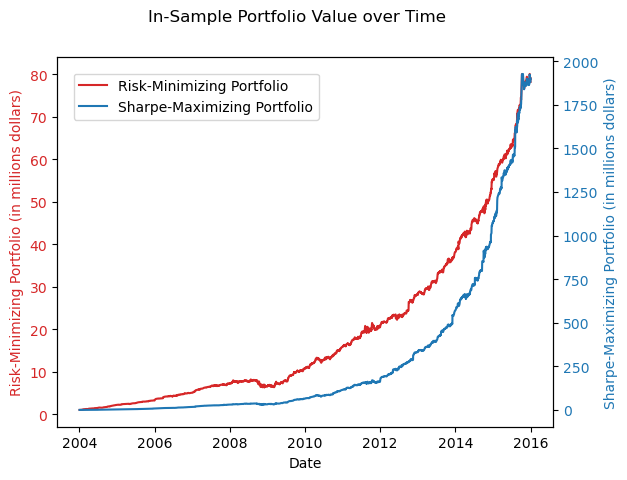

In [70]:
# In-sample portfolio value
# Create a figure and a single subplot
fig1, ax1 = plt.subplots()

# Plot the first data series on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Risk-Minimizing Portfolio (in millions dollars)', color=color)
ax1.plot(minRiskPortIns.index, minRiskPortIns['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sharpe-Maximizing Portfolio (in millions dollars)', color=color)  # we already handled the x-label with ax1
ax2.plot(maxSharpePortIns.index, maxSharpePortIns['maxSharpeVal'],
         color=color, label='Sharpe-Maximizing Portfolio')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
fig1.legend(loc='upper left', bbox_to_anchor=(0.14,0.86))
fig1.suptitle('In-Sample Portfolio Value over Time')
plt.show()


# Out of Sample

## Value Investing vs Growth Investing

In [71]:
strat = df1.copy()

# Calculate P/E using market value and net income. Since MV is in thousands,
# and net income is in millions, we divide by 1000.
strat['PE'] = strat['MV'] / strat['NI'] / 1000

# Rank the PE so that firms with smaller PE on each day has a smaller (closer to 0) rank
# Shift the PE by one day to avoid look-ahead bias
strat['PEValueRank'] = strat['PE'].shift().groupby('DATE').rank()

# Rank the PE so that firms with larger PE on each day has a smaller (closer to 0) rank
strat['PEGrowthRank'] = strat['PE'].shift().groupby('DATE').rank(ascending=False)

# Select the top 50 value stocks
PEValue50 = strat.loc[strat['PEValueRank'] < 50]

# Select the top 50 growth stocks
PEGrowth50 = strat.loc[strat['PEGrowthRank'] < 50]

# Construct an equal-weighted value portfolio everyday with top 50 value stocks
PEValuePort = PEValue50['RETX'].groupby('DATE').sum()/50
PEValuePort = PEValuePort.to_frame().merge(ff['RF'], how='left', on='DATE')
PEValuePort['ExcessRet'] = PEValuePort['RETX'] - PEValuePort['RF']

# Construct an equal-weighted growth portfolio everyday with top 50 growth stocks
PEGrowthPort = PEGrowth50['RETX'].groupby('DATE').sum()/50
PEGrowthPort = PEGrowthPort.to_frame().merge(ff['RF'], how='left', on='DATE')
PEGrowthPort['ExcessRet'] = PEGrowthPort['RETX'] - PEGrowthPort['RF']

In [72]:
PEValueRet = PEValuePort['RETX'].mean()
PEValueVol = PEValuePort['RETX'].std()
PEGrowthRet = PEGrowthPort['RETX'].mean()
PEGrowthVol = PEGrowthPort['RETX'].std()

In [73]:
print('Annulized return for PE Value portfolio: %2.4f' %(PEValueRet * 252))
print('Annulized return for PE Growth portfolio: %2.4f' %(PEGrowthRet * 252))
print('Annulized volatility for PE Value portfolio: %2.4f' %(PEValueVol * np.sqrt(252)))
print('Annulized volatility for PE Growth portfolio: %2.4f' %(PEGrowthVol * np.sqrt(252)))

Annulized return for PE Value portfolio: 0.2095
Annulized return for PE Growth portfolio: 0.2138
Annulized volatility for PE Value portfolio: 0.3513
Annulized volatility for PE Growth portfolio: 0.2723


In [74]:
PEValueSharpe = PEValuePort['ExcessRet'].mean() / PEValueVol * np.sqrt(252)
PEGrowthSharpe = PEGrowthPort['ExcessRet'].mean() / PEGrowthVol * np.sqrt(252)
print('Annulized Sharpe Ratio for PE Value portfolio: %2.4f' %(PEValueSharpe))
print('Annulized Sharpe Ratio for PE Growth portfolio: %2.4f' %(PEGrowthSharpe))

Annulized Sharpe Ratio for PE Value portfolio: 0.5588
Annulized Sharpe Ratio for PE Growth portfolio: 0.7365


## Investing in high earnings relative to total assets

In [75]:
strat = df1.copy()
strat['earnings'] = strat['IB'] / strat['Asset'] / 1000
strat['earningsRank'] = strat['earnings'].shift().groupby('DATE').rank(ascending=False)
earnings50 = strat.loc[strat['earningsRank'] < 50]
earningsPort = earnings50['RETX'].groupby('DATE').sum()/50

In [76]:
earningsStat = earningsPort.describe()

In [77]:
earningsRet = earningsStat['mean']
earningsVol = earningsStat['std']

In [78]:
print('Annulized return for high earning portfolio: %2.4f' %(earningsRet * 252))
print('Annulized volatility for high earning portfolio: %2.4f' %(earningsVol * np.sqrt(252)))

Annulized return for high earning portfolio: 0.5662
Annulized volatility for high earning portfolio: 0.3445


In [79]:
earningsPort = earningsPort.to_frame().merge(ff['RF'], how='left', on='DATE')
earningsPort['ExcessRet'] = earningsPort['RETX'] - earningsPort['RF']
earningsSharpe = earningsPort['ExcessRet'].mean() / earningsVol * np.sqrt(252)
print('Annulized Sharpe Ratio for high earning portfolio: %2.4f' %(earningsSharpe))

Annulized Sharpe Ratio for high earning portfolio: 1.6051


## Investing in high profit margins

In [80]:
strat = df1.copy()
strat['margin'] = strat['NI'] / strat['SALE'] / 1000
strat['marginRank'] = strat['margin'].shift().groupby('DATE').rank(ascending=False)
margin50 = strat.loc[strat['marginRank'] < 50]
marginPort = margin50['RETX'].groupby('DATE').sum()/50

In [81]:
marginStat = marginPort.describe()

In [82]:
marginRet = marginStat['mean']
marginVol = marginStat['std']

In [83]:
print('Annulized return for high margin portfolio: %2.4f' %(marginRet * 252))
print('Annulized volatility for high margin portfolio: %2.4f' %(marginVol * np.sqrt(252)))

Annulized return for high margin portfolio: 0.4876
Annulized volatility for high margin portfolio: 0.3430


In [84]:
marginPort = marginPort.to_frame().merge(ff['RF'], how='left', on='DATE')
marginPort['ExcessRet'] = marginPort['RETX'] - marginPort['RF']
marginSharpe = marginPort['ExcessRet'].mean() / marginVol * np.sqrt(252)
print('Annulized Sharpe Ratio for profitable portfolio: %2.4f' %(marginSharpe))

Annulized Sharpe Ratio for profitable portfolio: 1.3829


## Investing in small companies (SMB)

In [85]:
strat = df1.copy()
strat['sizeRank'] = strat['Asset'].shift().groupby('DATE').rank()
size50 = strat.loc[strat['sizeRank'] < 50]
sizePort = size50['RETX'].groupby('DATE').sum()/50

In [86]:
sizeStat = sizePort.describe()

In [87]:
sizeRet = sizeStat['mean']
sizeVol = sizeStat['std']

In [88]:
print('Annulized return for small company portfolio: %2.4f' %(sizeRet * 252))
print('Annulized volatility for small company portfolio: %2.4f' %(sizeVol * np.sqrt(252)))

Annulized return for small company portfolio: 2.8142
Annulized volatility for small company portfolio: 1.0879


In [89]:
sizePort = sizePort.to_frame().merge(ff['RF'], how='left', on='DATE')
sizePort['ExcessRet'] = sizePort['RETX'] - sizePort['RF']
sizeSharpe = sizePort['ExcessRet'].mean() / sizeVol * np.sqrt(252)
print('Annulized Sharpe Ratio for small company portfolio: %2.4f' %(sizeSharpe))

Annulized Sharpe Ratio for small company portfolio: 2.5747


# Double Moving Average (DMA)

In [90]:
# Compute the 10-, 50-, and 100-day moving averages
strat = df1.copy()

strat['7ma'] = strat.groupby('PERMNO')['PRC'].rolling(7).mean().droplevel(0)
strat['21ma'] = strat.groupby('PERMNO')['PRC'].rolling(21).mean().droplevel(0)

In [91]:
# Test the 7-, 21-day strategy
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['7ma'] > strat['21ma'], 'signal'] = 1
strat.loc[strat['7ma'] < strat['21ma'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['dmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
dmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['dmaRet'].groupby('DATE').sum()/50

dmaRet = dmaPort.mean()
dmaVol = dmaPort.std()
print('Annulized return for DMA portfolio: %2.4f' %(dmaRet * 252))
print('Annulized volatility for DMA portfolio: %2.4f' %(dmaVol * np.sqrt(252)))

Annulized return for DMA portfolio: 0.2036
Annulized volatility for DMA portfolio: 0.2133


In [92]:
dmaPort = dmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
dmaPort['ExcessRet'] = dmaPort['dmaRet'] - dmaPort['RF']
dmaSharpe = dmaPort['ExcessRet'].mean() / dmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DMA portfolio: %2.4f' %(dmaSharpe))

Annulized Sharpe Ratio for DMA portfolio: 0.8916


## Double Exponential Moving Average

In [93]:
# Calculate Exponential Moving Averages
strat = df1.copy()
strat['ema_10'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['ema_50'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

# Calculate the Double EMAs for the same periods
strat['dema_10'] = strat.groupby('PERMNO')['ema_10'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['dema_50'] = strat.groupby('PERMNO')['ema_50'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

# Calculate DEMA
strat['dema_10_final'] = 2 * strat['ema_10'] - strat['dema_10']
strat['dema_50_final'] = 2 * strat['ema_50'] - strat['dema_50']

In [94]:
# Test the trategy
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['dema_10_final'] > strat['dema_50_final'], 'signal'] = 1
strat.loc[strat['dema_10_final'] < strat['dema_50_final'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['demaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
demaPort = stratfilter.loc[stratfilter['volRank'] < 50]['demaRet'].groupby('DATE').sum()/50

demaRet = demaPort.mean()
demaVol = demaPort.std()
print('Annulized return for DEMA portfolio: %2.4f' %(demaRet * 252))
print('Annulized volatility for DEMA portfolio: %2.4f' %(demaVol * np.sqrt(252)))

Annulized return for DEMA portfolio: 0.3309
Annulized volatility for DEMA portfolio: 0.2021


In [95]:
demaPort = demaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
demaPort['ExcessRet'] = demaPort['demaRet'] - demaPort['RF']
demaSharpe = demaPort['ExcessRet'].mean() / demaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for DEMA portfolio: %2.4f' %(demaSharpe))

Annulized Sharpe Ratio for DEMA portfolio: 1.5717


## Guppy Multiple Moving Average (GMMA)

In [96]:
# Compute the 10-, 50-, and 100-day moving averages
strat = df1.copy()
strat['ema_3'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=3, adjust=False).mean())
strat['ema_5'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
strat['ema_8'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=8, adjust=False).mean())
strat['ema_10'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
strat['ema_12'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
strat['ema_15'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=15, adjust=False).mean())

strat['ema_30'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=30, adjust=False).mean())
strat['ema_35'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=35, adjust=False).mean())
strat['ema_40'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=40, adjust=False).mean())
strat['ema_45'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=45, adjust=False).mean())
strat['ema_50'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=50, adjust=False).mean())
strat['ema_60'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=60, adjust=False).mean())

In [97]:
# Compute the minimum and maximum for each group of EMA for easier signal construction.
strat['low_short'] = strat[['ema_3','ema_5','ema_8','ema_10','ema_12','ema_15']].min(axis=1)
strat['high_short'] = strat[['ema_3','ema_5','ema_8','ema_10','ema_12','ema_15']].max(axis=1)
strat['low_long'] = strat[['ema_30','ema_35','ema_40','ema_45','ema_50','ema_60']].min(axis=1)
strat['high_long'] = strat[['ema_30','ema_35','ema_40','ema_45','ema_50','ema_60']].max(axis=1)

# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['low_short'] > strat['high_long'], 'signal'] = 1
strat.loc[strat['high_short'] < strat['low_long'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['gmmaRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
gmmaPort = stratfilter.loc[stratfilter['volRank'] < 50]['gmmaRet'].groupby('DATE').sum()/50

gmmaRet = gmmaPort.mean()
gmmaVol = gmmaPort.std()

print('Annulized return for MACD portfolio: %2.4f' %(gmmaRet * 252))
print('Annulized volatility for MACD portfolio: %2.4f' %(gmmaVol * np.sqrt(252)))

Annulized return for MACD portfolio: -0.0252
Annulized volatility for MACD portfolio: 0.0432


In [98]:
gmmaPort = gmmaPort.to_frame().merge(ff['RF'], how='left', on='DATE')
gmmaPort['ExcessRet'] = gmmaPort['gmmaRet'] - gmmaPort['RF']
gmmaSharpe = gmmaPort['ExcessRet'].mean() / gmmaVol * np.sqrt(252)
print('Annulized Sharpe Ratio for GMMA portfolio: %2.4f' %(gmmaSharpe))

Annulized Sharpe Ratio for GMMA portfolio: -0.8742


## Moving Average Convergance/Divergence (MACD)

In [99]:
# Constructing 12- and 26-day EMA
strat = df1.copy()
strat['ema_12'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
strat['ema_26'] = strat.groupby('PERMNO')['PRC'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

strat['MACD'] = strat['ema_12'] - strat['ema_26']
strat['signal_line'] = strat.groupby('PERMNO')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

In [100]:
# Set signal to 1 for days the short MA exceeds the long MA, and -1 if the former is less than the latter.
strat['signal'] = 0
strat.loc[strat['MACD'] > strat['signal_line'], 'signal'] = 1
strat.loc[strat['MACD'] < strat['signal_line'], 'signal'] = -1

# Calculate daily strategy returns
strat['signal'] = strat.groupby('PERMNO')['signal'].shift(1)
strat['macdRet'] = strat['RET'] * strat['signal']

# Trade on the most liquid stocks
strat['lagSignal'] = strat['signal'].shift()
stratfilter = strat.loc[((strat['signal'] > 0) & (strat['lagSignal'] < 0))|
                     ((strat['signal'] < 0) & (strat['lagSignal'] > 0))]
stratfilter['volRank'] = stratfilter['VOL'].groupby('DATE').rank(ascending=False)
macdPort = stratfilter.loc[stratfilter['volRank'] < 50]['macdRet'].groupby('DATE').sum()/50

macdRet = macdPort.mean()
macdVol = macdPort.std()
print('Annulized return for MACD portfolio: %2.4f' %(macdRet * 252))
print('Annulized volatility for MACD portfolio: %2.4f' %(macdVol * np.sqrt(252)))

Annulized return for MACD portfolio: 0.4012
Annulized volatility for MACD portfolio: 0.2196


In [101]:
macdPort = macdPort.to_frame().merge(ff['RF'], how='left', on='DATE')
macdPort['ExcessRet'] = macdPort['macdRet'] - macdPort['RF']
macdSharpe = macdPort['ExcessRet'].mean() / macdVol * np.sqrt(252)
print('Annulized Sharpe Ratio for MACD portfolio: %2.4f' %(macdSharpe))

Annulized Sharpe Ratio for MACD portfolio: 1.7664


## Portfolio Construction

In [102]:
# Combine returns for all strategies for easy manipulation
returns = pd.concat([PEValuePort['RETX'],PEGrowthPort['RETX'],earningsPort['RETX'],marginPort['RETX'],
                    sizePort['RETX'],dmaPort['dmaRet'],demaPort['demaRet'], macdPort['macdRet']],
                    axis=1, keys=['value','growth','earning','margin','size','dma','dema','macd'])

returns.head()

,value,growth,earning,margin,size,dma,dema,macd
DATE,,,,,,,,
2016-01-04,-0.026347,-0.020456,-0.019849,-0.014327,-0.017668,NaN,NaN,NaN
2016-01-05,0.004578,-0.002113,-0.005639,-0.010641,-0.008923,NaN,NaN,NaN
2016-01-06,-0.012086,-0.009928,-0.017750,-0.026445,-0.012731,NaN,NaN,NaN
2016-01-07,-0.022689,-0.025097,-0.029646,-0.035277,-0.034334,NaN,0.023822,0.022537
2016-01-08,-0.016531,-0.007414,-0.019340,-0.008319,-0.014601,NaN,0.010803,0.011587


In [103]:
# ret is average return for each strategy, and cov_matrix is the covariance matrix
ret = np.array([PEValueRet,PEGrowthRet,earningsRet,marginRet,sizeRet,
               dmaRet,demaRet,macdRet])
rf = ff.loc['2016-01-01':]['RF'].mean()
cov_matrix = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].cov()
cov_matrix = np.array(cov_matrix)

In [104]:
portSPOOSWt = [mean_var_opt(ret.T * 252, cov_matrix * 252, rf * 252, 0.1)]
portSPOOSWt

[(array([-0.00313669, -0.01612712,  0.02621135,  0.01141013,  0.01556244,
          0.00952958,  0.02849821,  0.03723251]),
  0.09999999999999999,
  0.023818720023238316,
  3.5575541294511317)]

In [105]:
# Maximizing Sharpe Ratio
# mu = expected_returns.mean_historical_return(returns, returns_data=True)
# S = risk_models.sample_cov(returns, returns_data=True)

ef = EfficientFrontier(ret * 252, cov_matrix * 252)
weights = ef.max_sharpe(rf*252)
maxSharpeRes = ef.portfolio_performance(verbose=True)
clean_weights = ef.clean_weights()
maxSharpeWtOOS = []
for value in clean_weights.values():
    maxSharpeWtOOS.append(value)
print(maxSharpeWtOOS)

Expected annual return: 70.3%
Annual volatility: 19.6%
Sharpe Ratio: 3.51
[0.0, 0.0, 0.19103, 0.04083, 0.12543, 0.09274, 0.24602, 0.30394]


In [106]:
# Minimizing risk
# mu = expected_returns.mean_historical_return(returns, returns_data=True)
# S = risk_models.sample_cov(returns, returns_data=True)

ef = EfficientFrontier(ret * 252, cov_matrix * 252)
weights = ef.min_volatility()
minRiskRes = ef.portfolio_performance(verbose=True)
clean_weights = ef.clean_weights()
minRiskWtOOS = []
for value in clean_weights.values():
    minRiskWtOOS.append(value)
print(minRiskWtOOS)

Expected annual return: 30.0%
Annual volatility: 13.2%
Sharpe Ratio: 2.12
[0.07326, 0.19157, 0.06603, 0.00506, 0.00368, 0.28582, 0.21975, 0.15483]


In [107]:
# Creating S&P500 Return portfolio using in-sample weights
SPPortOOSInsWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * portSPInsWt[0][0]

# Calculate daily returns
SPPortOOSInsWt['ret'] = SPPortOOSInsWt.sum(axis=1)

# Calculate portfolio value if starts with $1
SPPortOOSInsWt['SPRetVal'] = (1 + SPPortOOSInsWt['ret']).cumprod()
SPPortOOSInsWt

,value,growth,earning,margin,size,dma,dema,macd,ret,SPRetVal
DATE,,,,,,,,,,
2016-01-04,-1.703318e-05,-7.012975e-05,-0.000412,-0.000151,-0.000318,NaN,NaN,NaN,-0.000968,0.999032
2016-01-05,2.959357e-06,-7.242502e-06,-0.000117,-0.000112,-0.000161,NaN,NaN,NaN,-0.000394,0.998638
2016-01-06,-7.813363e-06,-3.403490e-05,-0.000368,-0.000279,-0.000229,NaN,NaN,NaN,-0.000919,0.997720
2016-01-07,-1.466804e-05,-8.603937e-05,-0.000615,-0.000373,-0.000618,NaN,0.000876,0.001044,0.000213,0.997933
2016-01-08,-1.068713e-05,-2.541667e-05,-0.000401,-0.000088,-0.000263,NaN,0.000397,0.000537,0.000146,0.998078
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,5.835162e-08,1.458223e-05,-0.000053,-0.000077,-0.000084,0.000014,0.000329,0.000482,0.000625,2.147406
2023-09-26,-6.832725e-06,-5.069854e-05,-0.000266,-0.000152,0.000100,-0.000011,0.000176,0.000311,0.000101,2.147623
2023-09-27,5.411547e-06,3.695399e-05,0.000247,0.000052,0.000116,-0.000004,0.000049,0.000084,0.000586,2.148882


In [108]:
print('S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized return of %2.4f' %(SPPortOOSInsWt['ret'].mean() * 252))
print('S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of %2.4f' %(SPPortOOSInsWt['ret'].std() * np.sqrt(252)))
print('S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of %2.4f' %(SPPortOOSInsWt['ret'].mean()/SPPortOOSInsWt['ret'].std() * np.sqrt(252)))

S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized return of 0.0994
S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of 0.0280
S&P500 Return portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of 3.5511


In [109]:
# Creating S&P500 Return portfolio using out-of-sample weights
SPPortOOSOOSWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * portSPOOSWt[0][0]

# Calculate daily returns
SPPortOOSOOSWt['ret'] = SPPortOOSOOSWt.sum(axis=1)

# Calculate portfolio value if starts with $1
SPPortOOSOOSWt['SPRetVal'] = (1 + SPPortOOSOOSWt['ret']).cumprod()
SPPortOOSOOSWt

,value,growth,earning,margin,size,dma,dema,macd,ret,SPRetVal
DATE,,,,,,,,,,
2016-01-04,8.264373e-05,0.000330,-0.000520,-0.000163,-0.000275,NaN,NaN,NaN,-0.000546,0.999454
2016-01-05,-1.435858e-05,0.000034,-0.000148,-0.000121,-0.000139,NaN,NaN,NaN,-0.000388,0.999066
2016-01-06,3.790986e-05,0.000160,-0.000465,-0.000302,-0.000198,NaN,NaN,NaN,-0.000767,0.998299
2016-01-07,7.116827e-05,0.000405,-0.000777,-0.000403,-0.000534,NaN,0.000679,0.000839,0.000280,0.998579
2016-01-08,5.185315e-05,0.000120,-0.000507,-0.000095,-0.000227,NaN,0.000308,0.000431,0.000082,0.998660
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-2.831178e-07,-0.000069,-0.000067,-0.000083,-0.000073,0.000087,0.000255,0.000387,0.000437,1.943268
2023-09-26,3.315188e-05,0.000238,-0.000336,-0.000164,0.000086,-0.000069,0.000137,0.000250,0.000176,1.943610
2023-09-27,-2.625643e-05,-0.000174,0.000312,0.000056,0.000100,-0.000023,0.000038,0.000068,0.000350,1.944291


In [110]:
# Creating risk-minimizing portfolio using in-sample weights
minRiskPortOOSInsWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * minRiskWtIns

# Calculate daily returns
minRiskPortOOSInsWt['ret'] = minRiskPortOOSInsWt.sum(axis=1)

# Calculate portfolio value if starts with $1
minRiskPortOOSInsWt['minRiskVal'] = (1 + minRiskPortOOSInsWt['ret']).cumprod()
minRiskPortOOSInsWt

,value,growth,earning,margin,size,dma,dema,macd,ret,minRiskVal
DATE,,,,,,,,,,
2016-01-04,-1.791625e-05,-0.001708,-0.004294,-0.000035,-0.000260,NaN,NaN,NaN,-0.006315,0.993685
2016-01-05,3.112782e-06,-0.000176,-0.001220,-0.000026,-0.000131,NaN,NaN,NaN,-0.001551,0.992144
2016-01-06,-8.218439e-06,-0.000829,-0.003840,-0.000065,-0.000188,NaN,NaN,NaN,-0.004930,0.987253
2016-01-07,-1.542849e-05,-0.002095,-0.006413,-0.000087,-0.000506,NaN,0.008120,0.005245,0.004249,0.991447
2016-01-08,-1.124119e-05,-0.000619,-0.004184,-0.000021,-0.000215,NaN,0.003682,0.002697,0.001330,0.992766
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,6.137680e-08,0.000355,-0.000553,-0.000018,-0.000069,0.000992,0.003048,0.002419,0.006175,21.863825
2023-09-26,-7.186961e-06,-0.001235,-0.002771,-0.000036,0.000082,-0.000785,0.001635,0.001564,-0.001552,21.829885
2023-09-27,5.692103e-06,0.000900,0.002571,0.000012,0.000095,-0.000264,0.000457,0.000422,0.004198,21.921532


In [111]:
print('Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized return of %2.4f' %(minRiskPortOOSInsWt['ret'].mean() * 252))
print('Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of %2.4f' %(minRiskPortOOSInsWt['ret'].std() * np.sqrt(252)))
print('Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of %2.4f' %(minRiskPortOOSInsWt['ret'].mean()/minRiskPortOOSInsWt['ret'].std() * np.sqrt(252)))

Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized return of 0.4109
Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of 0.1455
Risk-minimizing portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of 2.8234


In [112]:
# Creating risk-minimizing portfolio using out-of-sample weights
minRiskPortOOSOOSWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * minRiskWtOOS

# Calculate daily returns
minRiskPortOOSOOSWt['ret'] = minRiskPortOOSOOSWt.sum(axis=1)

# Calculate portfolio value if starts with $1
minRiskPortOOSOOSWt['minRiskVal'] = (1 + minRiskPortOOSOOSWt['ret']).cumprod()
minRiskPortOOSOOSWt

,value,growth,earning,margin,size,dma,dema,macd,ret,minRiskVal
DATE,,,,,,,,,,
2016-01-04,-0.001930,-0.003919,-0.001311,-0.000072,-0.000065,NaN,NaN,NaN,-0.007297,0.992703
2016-01-05,0.000335,-0.000405,-0.000372,-0.000054,-0.000033,NaN,NaN,NaN,-0.000528,0.992178
2016-01-06,-0.000885,-0.001902,-0.001172,-0.000134,-0.000047,NaN,NaN,NaN,-0.004140,0.988071
2016-01-07,-0.001662,-0.004808,-0.001958,-0.000179,-0.000126,NaN,0.005235,0.003489,-0.000008,0.988063
2016-01-08,-0.001211,-0.001420,-0.001277,-0.000042,-0.000054,NaN,0.002374,0.001794,0.000164,0.988225
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.000007,0.000815,-0.000169,-0.000037,-0.000017,0.002608,0.001965,0.001609,0.006781,9.372088
2023-09-26,-0.000774,-0.002833,-0.000846,-0.000073,0.000020,-0.002065,0.001054,0.001041,-0.004476,9.330137
2023-09-27,0.000613,0.002065,0.000785,0.000025,0.000024,-0.000695,0.000295,0.000281,0.003392,9.361782


In [113]:
# Creating Sharpe-maximizing portfolio using in-sample weights
maxSharpePortOOSInsWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * maxSharpeWtIns

# Calculate daily returns
maxSharpePortOOSInsWt['ret'] = maxSharpePortOOSInsWt.sum(axis=1)

# Calculate portfolio value if starts with $1
maxSharpePortOOSInsWt['maxSharpeVal'] = (1 + maxSharpePortOOSInsWt['ret']).cumprod()
maxSharpePortOOSInsWt

,value,growth,earning,margin,size,dma,dema,macd,ret,maxSharpeVal
DATE,,,,,,,,,,
2016-01-04,-1.233059e-04,-0.000508,-0.002985,-0.001097,-0.002304,NaN,NaN,NaN,-0.007017,0.992983
2016-01-05,2.142326e-05,-0.000052,-0.000848,-0.000815,-0.001164,NaN,NaN,NaN,-0.002857,0.990145
2016-01-06,-5.656220e-05,-0.000247,-0.002669,-0.002025,-0.001660,NaN,NaN,NaN,-0.006657,0.983554
2016-01-07,-1.061843e-04,-0.000623,-0.004458,-0.002701,-0.004477,NaN,0.006344,0.007565,0.001543,0.985072
2016-01-08,-7.736583e-05,-0.000184,-0.002908,-0.000637,-0.001904,NaN,0.002877,0.003890,0.001056,0.986112
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,4.224168e-07,0.000106,-0.000384,-0.000557,-0.000609,0.000102,0.002382,0.003489,0.004528,221.673618
2023-09-26,-4.946320e-05,-0.000367,-0.001926,-0.001102,0.000723,-0.000081,0.001277,0.002256,0.000731,221.835722
2023-09-27,3.917506e-05,0.000268,0.001787,0.000377,0.000839,-0.000027,0.000357,0.000609,0.004249,222.778366


In [114]:
print('Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized return of %2.4f' %(maxSharpePortOOSInsWt['ret'].mean() * 252))
print('Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of %2.4f' %(maxSharpePortOOSInsWt['ret'].std() * np.sqrt(252)))
print('Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of %2.4f' %(maxSharpePortOOSInsWt['ret'].mean()/maxSharpePortOOSInsWt['ret'].std() * np.sqrt(252)))

Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized return of 0.7204
Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized standard deviation of 0.2029
Sharpe-maximizing portfolio in out-of-sample data using in-sample weights yields annualized Sharpe Ratio of 3.5511


In [115]:
# Creating Sharpe-maximizing portfolio using out-of-sample weights
maxSharpePortOOSOOSWt = returns[['value','growth','earning','margin','size',
                      'dma','dema','macd']].copy() * maxSharpeWtOOS

# Calculate daily returns
maxSharpePortOOSOOSWt['ret'] = maxSharpePortOOSOOSWt.sum(axis=1)

# Calculate portfolio value if starts with $1
maxSharpePortOOSOOSWt['maxSharpeVal'] = (1 + maxSharpePortOOSOOSWt['ret']).cumprod()
maxSharpePortOOSOOSWt

,value,growth,earning,margin,size,dma,dema,macd,ret,maxSharpeVal
DATE,,,,,,,,,,
2016-01-04,-0.0,-0.0,-0.003792,-0.000585,-0.002216,NaN,NaN,NaN,-0.006593,0.993407
2016-01-05,0.0,-0.0,-0.001077,-0.000434,-0.001119,NaN,NaN,NaN,-0.002631,0.990793
2016-01-06,-0.0,-0.0,-0.003391,-0.001080,-0.001597,NaN,NaN,NaN,-0.006067,0.984782
2016-01-07,-0.0,-0.0,-0.005663,-0.001440,-0.004307,NaN,0.005861,0.006850,0.001300,0.986062
2016-01-08,-0.0,-0.0,-0.003694,-0.000340,-0.001831,NaN,0.002658,0.003522,0.000314,0.986372
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.0,0.0,-0.000488,-0.000297,-0.000586,0.000846,0.002200,0.003159,0.004834,195.657692
2023-09-26,-0.0,-0.0,-0.002446,-0.000588,0.000696,-0.000670,0.001180,0.002043,0.000214,195.699559
2023-09-27,0.0,0.0,0.002270,0.000201,0.000807,-0.000226,0.000330,0.000551,0.003934,196.469458


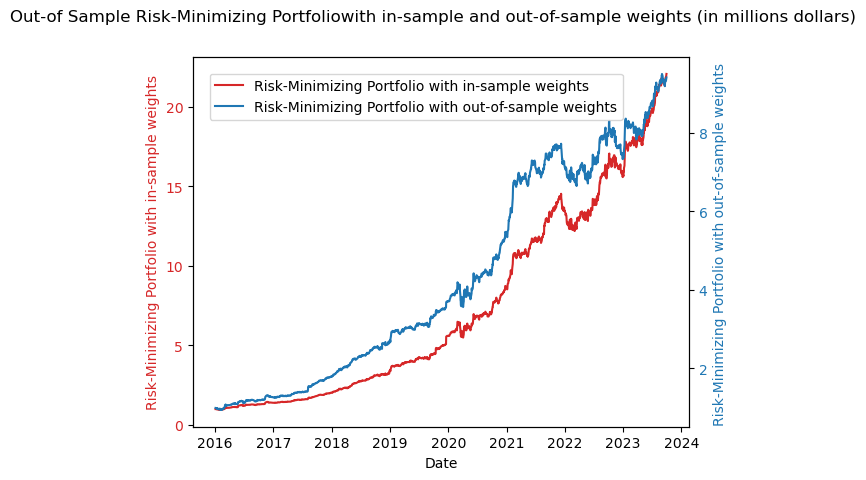

In [116]:
# Out-of-sample portfolio value
# Create a figure and a single subplot
fig2, ax1 = plt.subplots()

# Plot the first data series on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Risk-Minimizing Portfolio with in-sample weights', color=color)
ax1.plot(minRiskPortOOSInsWt.index, minRiskPortOOSInsWt['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio with in-sample weights')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Risk-Minimizing Portfolio with out-of-sample weights ', color=color)  # we already handled the x-label with ax1
ax2.plot(minRiskPortOOSOOSWt.index, minRiskPortOOSOOSWt['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio with out-of-sample weights')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
fig2.legend(loc='upper left', bbox_to_anchor=(0.14,0.86))
fig2.suptitle('Out-of Sample Risk-Minimizing Portfoliowith in-sample and out-of-sample weights (in millions dollars)')
plt.show()

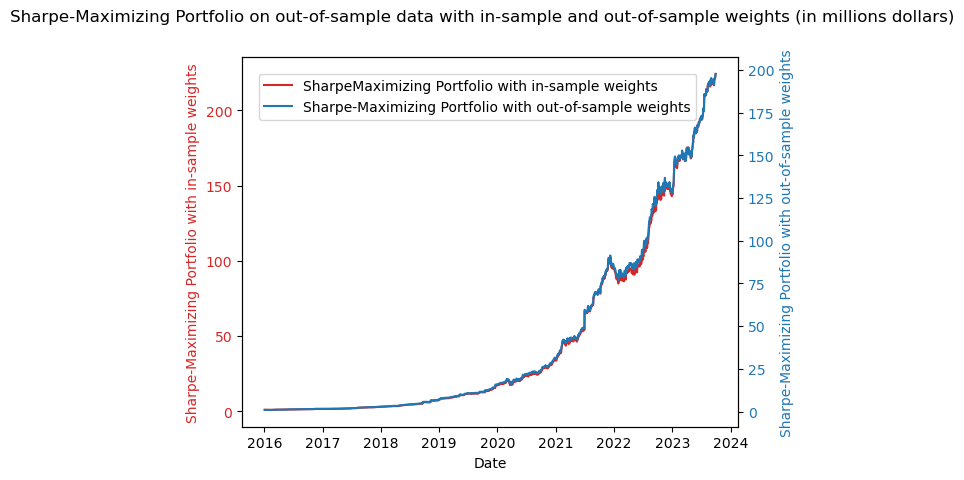

In [117]:
# Out-of-sample portfolio value
# Create a figure and a single subplot
fig3, ax1 = plt.subplots()

# Plot the first data series on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sharpe-Maximizing Portfolio with in-sample weights', color=color)
ax1.plot(maxSharpePortOOSInsWt.index, maxSharpePortOOSInsWt['maxSharpeVal'],
         color=color, label='SharpeMaximizing Portfolio with in-sample weights')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sharpe-Maximizing Portfolio with out-of-sample weights', color=color)  # we already handled the x-label with ax1
ax2.plot(maxSharpePortOOSOOSWt.index, maxSharpePortOOSOOSWt['maxSharpeVal'],
         color=color, label='Sharpe-Maximizing Portfolio with out-of-sample weights')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
fig3.legend(loc='upper left', bbox_to_anchor=(0.14,0.86))
fig3.suptitle('Sharpe-Maximizing Portfolio on out-of-sample data with in-sample and out-of-sample weights (in millions dollars)')
plt.show()

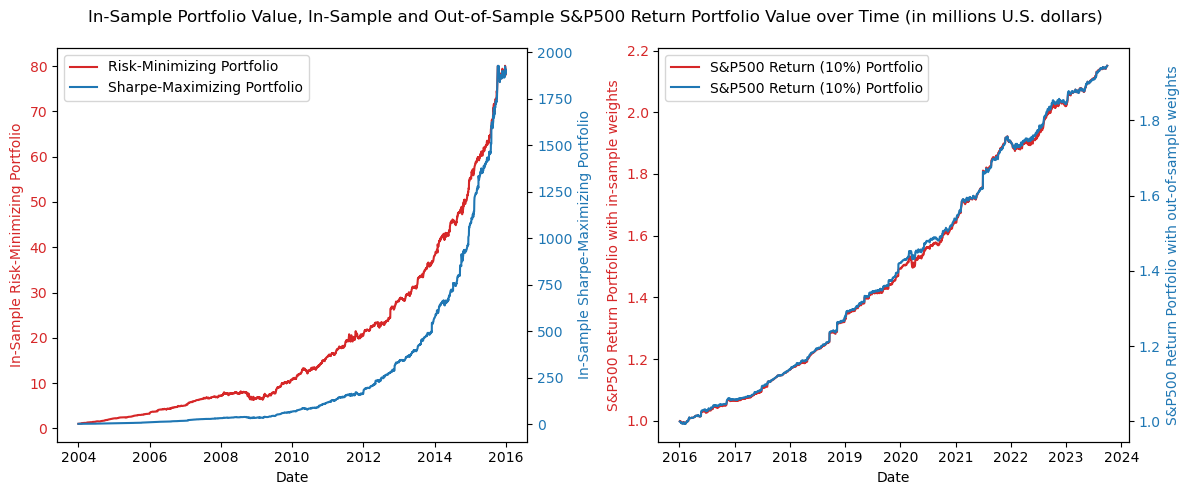

In [118]:
# In-sample and Out-of-Sample portfolio value
# Create a figure and a single subplot
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,5))

# Plot the first data series on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('In-Sample Risk-Minimizing Portfolio', color=color)
ax1.plot(minRiskPortIns.index, minRiskPortIns['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('In-Sample Sharpe-Maximizing Portfolio', color=color)  # we already handled the x-label with ax1
ax2.plot(maxSharpePortIns.index, maxSharpePortIns['maxSharpeVal'],
         color=color, label='Sharpe-Maximizing Portfolio')
ax2.tick_params(axis='y', labelcolor=color)

handlesIns1, labelsIns1 = ax1.get_legend_handles_labels()
handlesIns2, labelsIns2 = ax2.get_legend_handles_labels()
allHandlesIns, allLabelsIns = handlesIns1 + handlesIns2, labelsIns1 + labelsIns2
ax1.legend(allHandlesIns, allLabelsIns, loc='upper left')


# Plot the first data series on the first y-axis
color = 'tab:red'
ax3.set_xlabel('Date')
ax3.set_ylabel('S&P500 Return Portfolio with in-sample weights', color=color)
ax3.plot(SPPortOOSInsWt.index, SPPortOOSInsWt['SPRetVal'],
         color=color, label='S&P500 Return (10%) Portfolio')
ax3.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax4.set_ylabel('S&P500 Return Portfolio with out-of-sample weights', color=color)  # we already handled the x-label with ax3
ax4.plot(SPPortOOSOOSWt.index, SPPortOOSOOSWt['SPRetVal'],
         color=color, label='S&P500 Return (10%) Portfolio')
ax4.tick_params(axis='y', labelcolor=color)

handlesOos3, labelsOos3 = ax3.get_legend_handles_labels()
handlesOos4, labelsOos4 = ax4.get_legend_handles_labels()
allHandlesOos, allLabelsOos = handlesOos3 + handlesOos4, labelsOos3 + labelsOos4
ax3.legend(allHandlesOos, allLabelsOos, loc='upper left')


# Show the plot
# fig.legend(loc='upper left', bbox_to_anchor=(0.14,0.86))
fig.suptitle('In-Sample Portfolio Value, In-Sample and Out-of-Sample S&P500 Return Portfolio Value over Time (in millions U.S. dollars)')
plt.tight_layout()
plt.show()


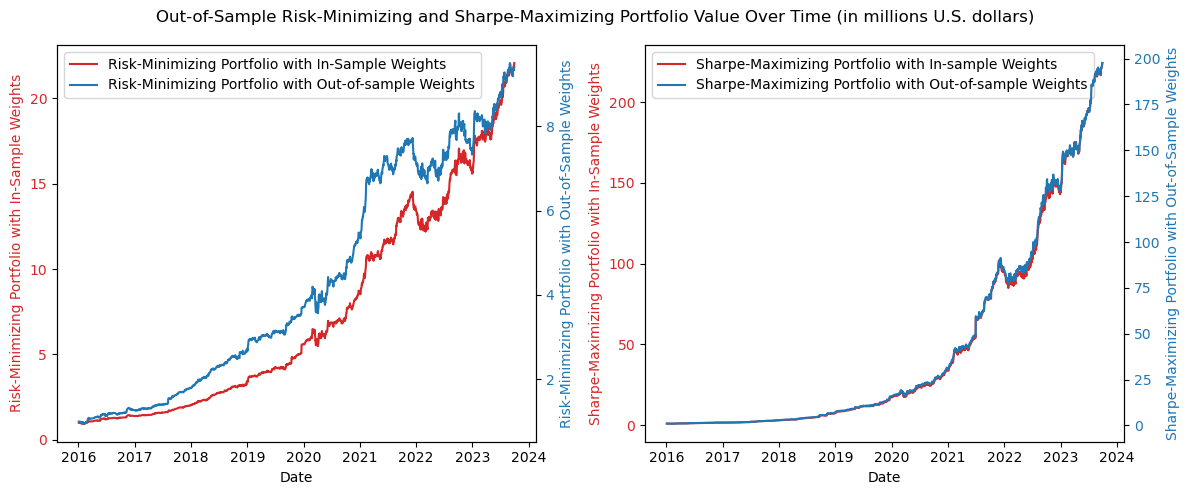

In [119]:
# In-sample and Out-of-Sample portfolio value
# Create a figure and a single subplot
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12,5))

# Plot the first data series on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Risk-Minimizing Portfolio with In-Sample Weights', color=color)
ax1.plot(minRiskPortOOSInsWt.index, minRiskPortOOSInsWt['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio with In-Sample Weights')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Risk-Minimizing Portfolio with Out-of-Sample Weights', color=color)  # we already handled the x-label with ax1
ax2.plot(minRiskPortOOSOOSWt.index, minRiskPortOOSOOSWt['minRiskVal'],
         color=color, label='Risk-Minimizing Portfolio with Out-of-sample Weights')
ax2.tick_params(axis='y', labelcolor=color)

handlesIns1, labelsIns1 = ax1.get_legend_handles_labels()
handlesIns2, labelsIns2 = ax2.get_legend_handles_labels()
allHandlesIns, allLabelsIns = handlesIns1 + handlesIns2, labelsIns1 + labelsIns2
ax1.legend(allHandlesIns, allLabelsIns, loc='upper left')


# Plot the first data series on the first y-axis
color = 'tab:red'
ax3.set_xlabel('Date')
ax3.set_ylabel('Sharpe-Maximizing Portfolio with In-Sample Weights', color=color)
ax3.plot(maxSharpePortOOSInsWt.index, maxSharpePortOOSInsWt['maxSharpeVal'],
         color=color, label='Sharpe-Maximizing Portfolio with In-sample Weights')
ax3.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data series
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax4.set_ylabel('Sharpe-Maximizing Portfolio with Out-of-Sample Weights', color=color)  # we already handled the x-label with ax3
ax4.plot(maxSharpePortOOSOOSWt.index, maxSharpePortOOSOOSWt['maxSharpeVal'],
         color=color, label='Sharpe-Maximizing Portfolio with Out-of-sample Weights')
ax4.tick_params(axis='y', labelcolor=color)

handlesOos3, labelsOos3 = ax3.get_legend_handles_labels()
handlesOos4, labelsOos4 = ax4.get_legend_handles_labels()
allHandlesOos, allLabelsOos = handlesOos3 + handlesOos4, labelsOos3 + labelsOos4
ax3.legend(allHandlesOos, allLabelsOos, loc='upper left')


# Show the plot
# fig.legend(loc='upper left', bbox_to_anchor=(0.14,0.86))
fig.suptitle('Out-of-Sample Risk-Minimizing and Sharpe-Maximizing Portfolio Value Over Time (in millions U.S. dollars)')
plt.tight_layout()
plt.show()
